In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_columns', 50)
print('Libraries loaded.')

Libraries loaded.


In [2]:
DATA_PATH = 'storage_logs.csv'  # Ensure this file is in the same folder
df = pd.read_csv(DATA_PATH)
df['Last_Access_Date'] = pd.to_datetime(df['Last_Access_Date'], errors='coerce')
print(df.shape)
df.head()
     

(3000, 7)


,File_ID,Department,File_Type,Size_GB,Last_Access_Date,Storage_Tier,Monthly_Cost_USD
0,F00001,Engineering,Backup,1.97,2024-02-02,S3 IA,0.0246
1,F00002,Sales,Other,0.10,2023-12-16,S3 Standard,0.0023
2,F00003,Marketing,Document,7.15,2024-07-10,S3 IA,0.0894
3,F00004,Sales,Other,0.22,2024-03-22,S3 Standard,0.0051
4,F00005,Sales,Media,10.00,2023-11-19,S3 Standard,0.2300


In [3]:
missing = df.isna().sum()
duplicates = df.duplicated().sum()
print('Missing values by column:\n', missing)
print('\nDuplicate rows:', duplicates)
df.describe(include='all')

Missing values by column:
 File_ID             0
Department          0
File_Type           0
Size_GB             0
Last_Access_Date    0
Storage_Tier        0
Monthly_Cost_USD    0
dtype: int64

Duplicate rows: 0


,File_ID,Department,File_Type,Size_GB,Last_Access_Date,Storage_Tier,Monthly_Cost_USD
count,3000,3000,3000,3000.000000,3000,3000,3000.000000
unique,3000,5,5,NaN,NaN,3,NaN
top,F00001,Engineering,Backup,NaN,NaN,S3 Standard,NaN
freq,1,620,626,NaN,NaN,1791,NaN
mean,NaN,NaN,NaN,4.959360,2024-09-09 14:50:52.800000256,NaN,0.089591
min,NaN,NaN,NaN,0.000000,2023-09-07 00:00:00,NaN,0.000000
25%,NaN,NaN,NaN,1.477500,2024-03-10 00:00:00,NaN,0.020600
50%,NaN,NaN,NaN,3.510000,2024-09-13 00:00:00,NaN,0.056000
75%,NaN,NaN,NaN,6.850000,2025-03-08 00:00:00,NaN,0.123400
max,NaN,NaN,NaN,44.000000,2025-09-06 00:00:00,NaN,0.841600


In [4]:
TODAY = pd.Timestamp.today().normalize()
df['Days_Since_Access'] = (TODAY - df['Last_Access_Date']).dt.days
tier_cost = {'S3 Standard': 0.023, 'S3 IA': 0.0125, 'Glacier': 0.004}
df['Cost_per_GB'] = df['Storage_Tier'].map(tier_cost)
df['Current_Monthly_Cost'] = (df['Size_GB'] * df['Cost_per_GB']).round(4)
df.head()

,File_ID,Department,File_Type,Size_GB,Last_Access_Date,Storage_Tier,Monthly_Cost_USD,Days_Since_Access,Cost_per_GB,Current_Monthly_Cost
0,F00001,Engineering,Backup,1.97,2024-02-02,S3 IA,0.0246,744,0.0125,0.0246
1,F00002,Sales,Other,0.10,2023-12-16,S3 Standard,0.0023,792,0.0230,0.0023
2,F00003,Marketing,Document,7.15,2024-07-10,S3 IA,0.0894,585,0.0125,0.0894
3,F00004,Sales,Other,0.22,2024-03-22,S3 Standard,0.0051,695,0.0230,0.0051
4,F00005,Sales,Media,10.00,2023-11-19,S3 Standard,0.2300,819,0.0230,0.2300


In [5]:
glacier_cost_per_gb = 0.004
df['Is_Cold'] = df['Days_Since_Access'] > 180
df['Proposed_Tier'] = np.where(df['Is_Cold'] & (df['Storage_Tier'] != 'Glacier'), 'Glacier', df['Storage_Tier'])
df['Proposed_Cost'] = (df['Size_GB'] * np.where(df['Proposed_Tier']=='Glacier', glacier_cost_per_gb, df['Cost_per_GB'])).round(4)
df['Potential_Savings'] = (df['Current_Monthly_Cost'] - df['Proposed_Cost']).clip(lower=0).round(4)
df[['File_ID','Department','Storage_Tier','Is_Cold','Size_GB','Current_Monthly_Cost','Proposed_Tier','Proposed_Cost','Potential_Savings']].head()

,File_ID,Department,Storage_Tier,Is_Cold,Size_GB,Current_Monthly_Cost,Proposed_Tier,Proposed_Cost,Potential_Savings
0,F00001,Engineering,S3 IA,True,1.97,0.0246,Glacier,0.0079,0.0167
1,F00002,Sales,S3 Standard,True,0.10,0.0023,Glacier,0.0004,0.0019
2,F00003,Marketing,S3 IA,True,7.15,0.0894,Glacier,0.0286,0.0608
3,F00004,Sales,S3 Standard,True,0.22,0.0051,Glacier,0.0009,0.0042
4,F00005,Sales,S3 Standard,True,10.00,0.2300,Glacier,0.0400,0.1900


In [6]:
total_cost = df['Current_Monthly_Cost'].sum()
potential_savings = df['Potential_Savings'].sum()
cold_ratio = df['Is_Cold'].mean()
kpis = pd.DataFrame({
    'Metric': ['Total Current Monthly Cost (USD)', 'Total Potential Monthly Savings (USD)', 'Cold Data Ratio'],
    'Value': [round(total_cost,2), round(potential_savings,2), round(cold_ratio*100,2)]
})
kpis

,Metric,Value
0,Total Current Monthly Cost (USD),268.77
1,Total Potential Monthly Savings (USD),202.04
2,Cold Data Ratio,97.03


In [7]:
dept_summary = df.groupby('Department').agg(
    Files=('File_ID','count'),
    Size_GB=('Size_GB','sum'),
    Current_Cost=('Current_Monthly_Cost','sum'),
    Potential_Savings=('Potential_Savings','sum'),
    Cold_Share=('Is_Cold','mean')
).reset_index()
dept_summary['Cold_Share'] = (dept_summary['Cold_Share']*100).round(2)
dept_summary.sort_values('Potential_Savings', ascending=False)

,Department,Files,Size_GB,Current_Cost,Potential_Savings,Cold_Share
2,HR,618,3107.00,57.7277,43.7569,97.09
0,Engineering,620,3286.22,57.6206,42.7627,96.61
1,Finance,584,2818.82,52.0884,39.6466,96.23
4,Sales,613,3063.09,53.7868,39.2164,97.06
3,Marketing,565,2602.95,47.5507,36.6616,98.23


In [8]:
type_summary = df.groupby('File_Type').agg(
    Files=('File_ID','count'),
    Size_GB=('Size_GB','sum'),
    Current_Cost=('Current_Monthly_Cost','sum'),
    Potential_Savings=('Potential_Savings','sum'),
    Cold_Share=('Is_Cold','mean')
).reset_index()
type_summary['Cold_Share'] = (type_summary['Cold_Share']*100).round(2)
type_summary.sort_values('Potential_Savings', ascending=False)
     

,File_Type,Files,Size_GB,Current_Cost,Potential_Savings,Cold_Share
4,Other,610,3126.13,57.2760,43.7030,97.54
0,Backup,626,3127.46,54.8821,41.2625,96.96
3,Media,581,2887.56,52.1383,39.2672,96.73
1,Document,591,2747.69,51.2878,39.2620,97.63
2,Log,592,2989.24,53.1900,38.5495,96.28


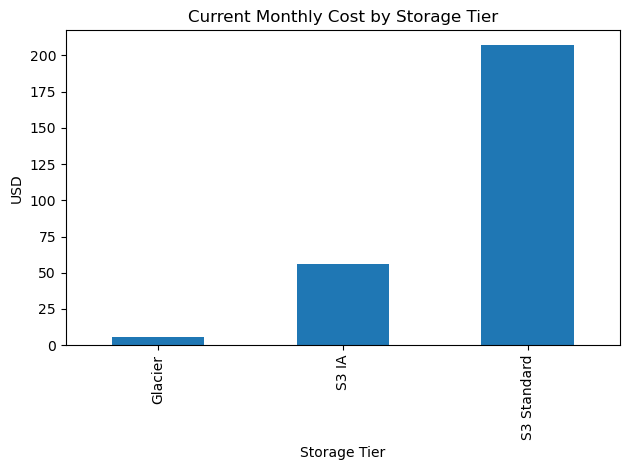

In [9]:
# 9.1 Current cost by storage tier
tier_costs = df.groupby('Storage_Tier')['Current_Monthly_Cost'].sum().sort_values()
plt.figure()
tier_costs.plot(kind='bar')
plt.title('Current Monthly Cost by Storage Tier')
plt.ylabel('USD')
plt.xlabel('Storage Tier')
plt.tight_layout()
plt.show()

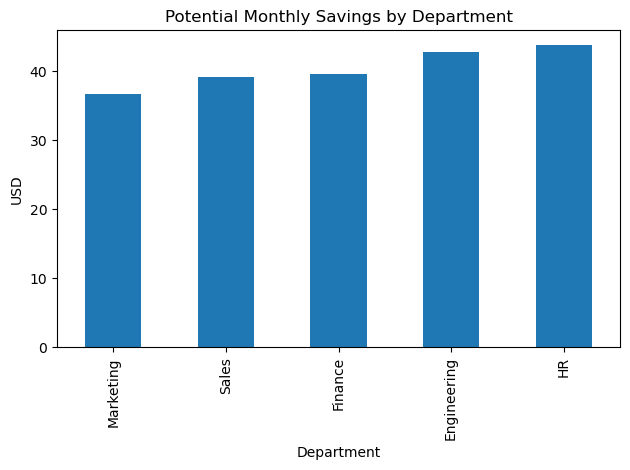

In [10]:
# 9.2 Potential savings by department
dept_savings = df.groupby('Department')['Potential_Savings'].sum().sort_values()
plt.figure()
dept_savings.plot(kind='bar')
plt.title('Potential Monthly Savings by Department')
plt.ylabel('USD')
plt.xlabel('Department')
plt.tight_layout()
plt.show()

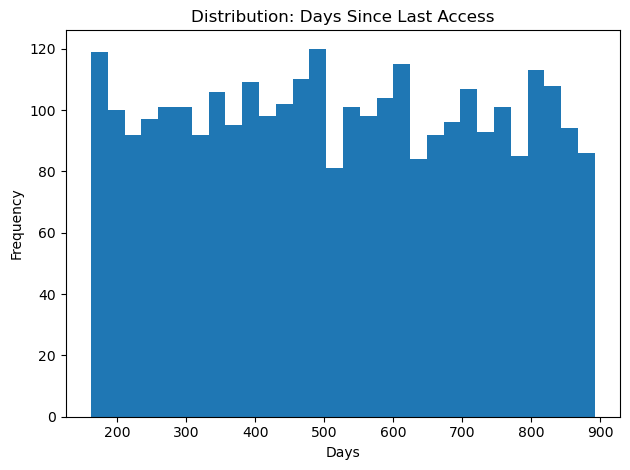

In [11]:
# 9.3 Distribution of days since last access
plt.figure()
df['Days_Since_Access'].dropna().plot(kind='hist', bins=30)
plt.title('Distribution: Days Since Last Access')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [12]:
export_dir = 'outputs'
import os
os.makedirs(export_dir, exist_ok=True)
kpis.to_csv(os.path.join(export_dir,'kpis_summary.csv'), index=False)
dept_summary.to_csv(os.path.join(export_dir,'department_summary.csv'), index=False)
type_summary.to_csv(os.path.join(export_dir,'filetype_summary.csv'), index=False)
recommendations = df.loc[(df['Is_Cold']) & (df['Storage_Tier']!='Glacier'),                          ['File_ID','Department','File_Type','Size_GB','Days_Since_Access','Storage_Tier','Proposed_Tier','Potential_Savings']]
recommendations.sort_values('Potential_Savings', ascending=False).to_csv(os.path.join(export_dir,'file_level_recommendations.csv'), index=False)
print('Exports written to', export_dir)

Exports written to outputs
